In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import re,os
import glob, traceback
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

## 0. Read all csv files

In [2]:
df = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2020.csv')
df.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df = df.loc[:, ~df.columns.str.match('Unnamed')]

df_r = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2020_race.csv')
df_r.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_r = df_r.loc[:, ~df_r.columns.str.match('Unnamed')]

df_2020 = pd.merge(df, df_r[['id', 'user_id', 'race']],  how='left', on=['id','user_id'])
df_2020.shape

df.shape, df_r.shape, df_2020.shape

((3502171, 17), (2275943, 18), (3502171, 18))

In [3]:
drug_keywords_map= {
# 'tobacco' : ['nicotine', 'tobacco', 'cigarette', 'cigarrette', 'cigar', 'bidis', 'snuff'],
'alcohol' : ['liquor', 'beer', 'wine'],
# 'cannabinoids' : ['marijuana', 'blunt', 'dope', 'ganja', 'grass', 'herb', 'joint', 'bud', 'mary jane', 'pot', 'reefer', 'green', 'trees', 'smoke', 'sinsemilla', 'skunk', 'weed','hashish', 'boom', 'gangster', 'hash', 'hash oil', 'hemp'],
# 'opioids' : ['heroin', 'smack', 'horse', 'brown sugar', 'dope', 
#              # 'H',
#              'junk', 'skag', 'skunk', 'white horse', 'China white','opium', 'laudanum', 'paregoric', 'big O', 'black stuff', 'block', 'gum', 'hop'],
# 'stimulants': ['cocaine', 'hydrochloride', 'blow', 'bump',
#                # 'C',
#                 'candy', 'Charlie', 'coke', 'crack', 'flake', 'rock', 'snow', 'toot','amphetamine', 'Biphetamine', 'Dexedrine', 'bennies', 'black beauties', 'crosses', 'hearts', 'LA turnaround', 'speed', 'truck drivers', 'uppers','methamphetamine', 'Desoxyn','meth', 'ice', 'crank', 'chalk', 'crystal', 'fire', 'glass', 'go fast', 'speed'],
# 'club_drugs':['mdma', 'ecstasy', 'adam', 'clarity', 'eve', "lover's speed", 'peace', 'uppers','flunitrazepam', 'rohypnol', 'forget-me pill', 'mexican valium', 'r2', 'roach', 'roche', 'roffles', 'roofinol', 'rope', 'rophies','ghb', 'Gamma-hydroxybutyrate', 
#               # 'G',
#               'Georgia home boy', 'grievous bodily harm', 'liquid ecstasy', 'soap', 'scoop', 'goop', 'liquid X'],
# 'dissociative_drugs':['ketamine', 'Ketalar SV', 'cat Valium',
#                       # 'K',
#                       'Special K', 'vitamin K','pcp and analogs', 'phencyclidine' 'angel dust', 'boat', 'hog', 'love boat', 'peace pill','salvia divinorum', 'salvia', 'shepherdess’s herb', 'maria pastora', 'magic mint', 'sally-d','dextromethorphan', 'dxm',  'robotripping', 'robo', 'triple'],
# 'hallucinogens':['lsd','Lysergic acid diethylamide', 'acid', 'blotter', 'cubes', 'microdot', 'yellow sunshine', 'blue heaven', 'mescaline', 'Buttons', 'cactus', 'mesc', 'peyote', 'psilocybin', 'Magic mushrooms', 'purple passion', 'shrooms', 'little smoke'],
# 'other_compounds':['anabolic_steroids', 'Anadrol', 'Oxandrin', 'Durabolin', 'Depo-Testosterone', 'Equipoise', 'roids', 'juice', 'gym candy', 'pumpers','inhalants', 'Solvents', 'paint thinners', 'gasoline', 'glues', 'gasses', 'butane', 'propane', 'aerosol propellants', 'nitrous oxide',  'nitrites' ,'isoamyl', 'isobutyl', 'cyclohexyl','laughing gas', 'poppers', 'snappers', 'whippets'],
# 'prescription_medications':['cns_depressants', 'stimulants', 'opioid pain relievers', 'OxyContin','Oxycodone', 'Vicodin', 'Norco', 'Lortab', 'Hydrocodone', 'Acetaminophen', 'Percocet ', 'Oxycodone', 'Acetaminophen','Tramadol','Codeine','Morphine','Methadone','Demerol', 'meperidine','Acetaminophen','Tylenol', 'Excedrin', 'Vanquish','Aspirin', 'Bayer', 'Bufferin', 'Ecotrin', 'Excedrin', 'Vanquish','Diclofenac', 'Voltaren Gel','Ibuprofen', 'Advil', 'Motrin IB','Naproxen', 'Aleve']
}

drug_cols = drug_keywords_map.keys()

In [4]:
# https://nida.nih.gov/sites/default/files/cadchart.pdf
for keyword, words in drug_keywords_map.items():
    pattern = fr'\b(?:{"|".join(words)})\b'
    df_2020[keyword] = df_2020['text'].str.contains(pattern, case=False).astype(int)

In [5]:
df_2020['drug_type'] = df_2020[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)

## Theme analysis

In [6]:
covid = ['covid', 'corona', 'coronavirus', 'outbreak', 'spread', 'viral','virus', 'flu', 'infect','pcr test', 'national emergency', 'wuhan', 'CDC', 'ncov', 'SARS', 'mask', 'sanitizer',
         'toll', 'new disease', 'news', 'positive', 'test', 'cases',  'dangerous year', 'fake year', 'fda', 'flatten', 'cov2', 'quarantine', 'lockdown',
         'pandemic', 'epidemic', 'ventilator', 'symptomatic', 'incubation', 'transmission', 'immune', 'vaccine',
          'hard to breath', 'shortness of breath','start nose', 'variant']

economic =  ['job', 'job loss', 'jobless', 'no job', 'lost job', 'income', 'salary', 'paycheck', 'money', 'bills', 'bill raise',  'check', 'saving', 'wage','fulltime',
             'unemployed', 'economy', 'layoff', 'recession', 'stimulus', 'evict', 'laid', 'bankrupt', 'owe', 'afford',  'eviction', 'credit', 'debt', 'loan', 'financial crisis', 'inflation',
              'poor', 'poverty', 'normalize risk', 'cost', 'homeless', 'rent', 'mortgage', 'no food',  'no shelter', 'wallet', 'hungry street', 'fda']

social = ['lockdown', 'bully', "loneliness", "emptiness", "lonely", "distancing", "insecurities", "no one care", "trap", "feel ignore", "ignored", 'bored', 
         'quarantine', 'alone', 'stay home', 'stayhome', 'stay safe', 'stayathome', 'single', 'solo', 'lockup', 'disconnect', 
          'silence', 'off limit',  'frayed', 'indoor']

mentalhealth = ['sad', 'angry', 'mad', 'tension', 'depress', 'tire', 'exhausted', 'fear', 'scared', 'stress', 'worry', 'disappear', 'selfharm', 'crisis', 'dizzi', 'no hunger', 'no sleep','no hope', 'hopeless', 'loneliness', 'no will', 'quit life', 'no motivation', 'no motif', 'no focus', 'no dedication', 'cannot focus',
                'panic', 'panic attack', 'rapid heartbeat','heartbeat fast', 'suicidal thought', 'ending my life', 'no reason to live', 'feeling worthless',  'seeking a way out', 'feel like a burden', 'struggling to cope', 'lack of purpose', 'wanting the pain to stop',
                'mental pain', 'mental anguish', 'feel pressure', 'feel trapped', 'desperation', 'broken inside', 'losing the will to live','dark thought', 'depression', 'anxiety', 'ptsd', 'bipolar',
               'intrusive', 'trauma', 'burnout', 'grief', 'dyingfeel', 'sorrow']

supply_disruption = ['steal', 'deliver', 'refuse', 'small rate', 'sellout', 'sell bath', 'sell illegal', 'sell weed', 'cheap deal', 'box sale', 'sale', 'order', 'order pack', 'cut safe', 'strong', 'weak', 'legal high', 
                     'dangerous', 'toxic', 'industry', 'contaminated', 'local', 'import', 'international', 'darknet',  'market', 'stock alert', 'batch', 'customs', 'seizure', 'permit', 'lack', 'shortage', 'crisis', 'sale', 'buy drug', 'supply']

medical_disruption = ['health crisis', 'shut down', 'cut off', 'on hold',  'locked out', 'dead end', 
                      'dry', 'mia',  
                      'rehab', 'virtual', 'telehealth', 'teletherapy', 'telemedicine', 'appointment',  'close clinic', 'limited hours',
                       'waitlist', 'treatment full', 'medical line', 'freeze', 'overload', 'emergency','drought', 'no help line', 'pharmacy', 'customer service']
factor_keywords_map = {
                 'covid': covid,
                 'economic': economic,
                 'social' : social,
                 'mentalhealth': mentalhealth,
                 'supply_disruption': supply_disruption,
                 'medical_disruption': medical_disruption
                }

for keyword, words in factor_keywords_map.items():
    pattern = fr'\b(?:{"|".join(words)})\b'
    df_2020[keyword] = df_2020['text'].str.contains(pattern, case=False).astype(int)

In [7]:
df_2020['created_at'] = pd.to_datetime(df_2020['created_at'], format='%a %b %d %H:%M:%S %z %Y')

In [8]:
sub_data = df_2020[df_2020['drug_type']=='alcohol']

In [9]:
results = pd.DataFrame()
periods = [
    ('2020-02-01', '2020-02-14'),
    ('2020-02-15', '2020-02-28'),
    ('2020-03-01', '2020-03-14'),
    ('2020-03-15', '2020-03-31'),
    ('2020-04-01', '2020-04-14'),
    ('2020-04-15', '2020-04-30'),
    ('2020-05-01', '2020-05-14'),
    ('2020-05-15', '2020-05-31')
]
for i, (start_date, end_date) in enumerate(periods, 1):
    period_data = sub_data[(sub_data['created_at'] >= start_date) & (sub_data['created_at'] <= end_date)]
    counts = period_data[['covid', 'economic', 'social', 'mentalhealth', 'supply_disruption', 'medical_disruption']].sum()
    percentages = (counts / len(period_data)) * 100
    # combined = counts.astype(str) + ' (' + percentages.round(2).astype(str) + '%)'
    combined =  percentages.round(2).astype(str) + '%'

    combined.name = f'{start_date}'
    
    if results.empty:
        results = pd.DataFrame(combined)
    else:
        results = results.join(pd.DataFrame(combined))

results.T

,covid,economic,social,mentalhealth,supply_disruption,medical_disruption
2020-02-01,1.45%,1.81%,0.65%,0.72%,2.85%,0.3%
2020-02-15,1.5%,1.36%,0.71%,0.65%,2.84%,0.32%
2020-03-01,11.15%,4.71%,1.9%,1.22%,2.91%,0.32%
2020-03-15,12.1%,1.61%,8.57%,4.62%,7.4%,4.11%
2020-04-01,5.32%,1.55%,3.4%,1.05%,3.8%,0.63%
2020-04-15,4.86%,1.85%,4.14%,0.94%,3.74%,0.46%
2020-05-01,10.46%,2.88%,3.86%,0.98%,5.57%,0.52%
2020-05-15,2.79%,1.62%,1.58%,0.73%,3.61%,0.45%


In [27]:
df = results.T
df.reset_index(inplace=True)
df.rename(columns={'index': 'Week'},inplace=True)
df.rename(columns={'covid': 'Covid', 'economic':'Economic', 'social':'Social', 'supply_disruption':' Supply Disruption', 'mentalhealth' :'Mental Health', 'medical_disruption': 'Medical Disruption'}, inplace=True)
df

,Week,Covid,Economic,Social,Mental Health,Supply Disruption,Medical Disruption
0,2020-02-01,1.45%,1.81%,0.65%,0.72%,2.85%,0.3%
1,2020-02-15,1.5%,1.36%,0.71%,0.65%,2.84%,0.32%
2,2020-03-01,11.15%,4.71%,1.9%,1.22%,2.91%,0.32%
3,2020-03-15,12.1%,1.61%,8.57%,4.62%,7.4%,4.11%
4,2020-04-01,5.32%,1.55%,3.4%,1.05%,3.8%,0.63%
5,2020-04-15,4.86%,1.85%,4.14%,0.94%,3.74%,0.46%
6,2020-05-01,10.46%,2.88%,3.86%,0.98%,5.57%,0.52%
7,2020-05-15,2.79%,1.62%,1.58%,0.73%,3.61%,0.45%


In [123]:
from matplotlib import font_manager

def plot_tables_side_by_side(table, layout=(1, 2)):
    fig, ax = plt.subplots(figsize=(12, 5))
    filename = 'By Theme'
    ax.axis('off') 
    font_prop = font_manager.FontProperties(size=16)
    col_labels = [label.replace(' ', '\n') for label in table.columns]
    table_obj = ax.table(cellText=table.values, colLabels=col_labels, cellLoc='center', 
                         loc='center', bbox=[0, 0, 1, 1],
                         edges='closed')  
    
    for i, key in enumerate(table_obj.get_celld().keys()):
        cell = table_obj.get_celld()[key]
        cell.set_edgecolor('white')  
        cell.set_linewidth(1)  

        if key[0] == 0:  
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#003366')  # Dark blue
            cell.set_height(0.09) 

        else:
            # cell.set_fontsize("10")
            cell.set_text_props(color='black')
            if key[0] % 2 == 0:
                cell.set_facecolor('#f0f0f0')  # Light gray
            else:
                cell.set_facecolor('#ffffff')  # White
        if key[1] == 0:   # First column
            cell.set_text_props(horizontalalignment='left')

    # table_obj.auto_set_column_width([ 2])  # Automatically adjust width of the second and third columns
    table_obj.set_fontsize(12)           
    plt.subplots_adjust(top=0.90)  
    # if mailfile:
        # fig.suptitle('Drug User Demographics in 2020' , fontsize=16)
    plt.savefig('themes_alcohol_peak_pandemic_big_font.png', bbox_inches='tight')
    plt.show()


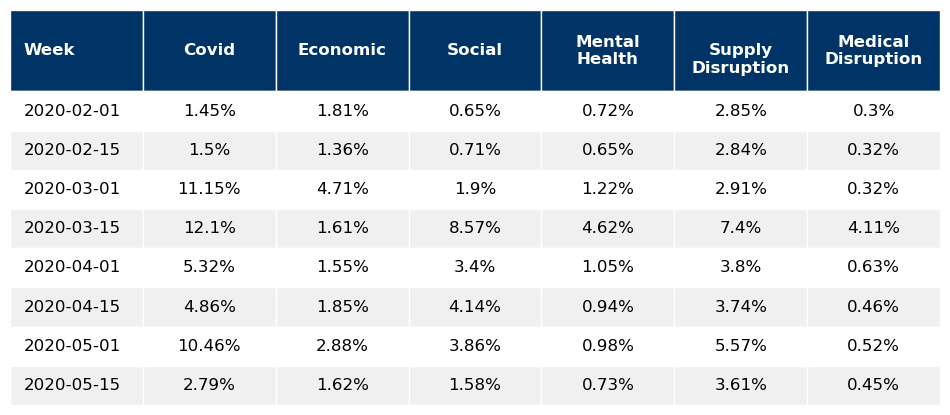

In [124]:
plot_tables_side_by_side(df)

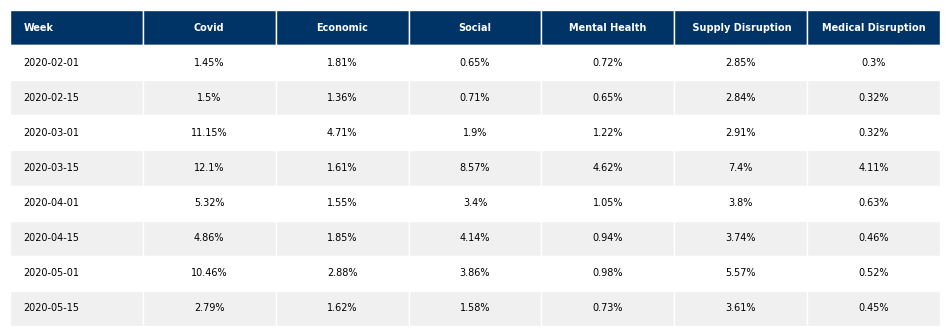

In [13]:
plot_tables_side_by_side(df)

In [14]:
pandemic= sub_data[(sub_data['created_at'] >= '2020-03-07') & (sub_data['created_at'] <= '2020-03-15')]
pandemic.shape

(8819, 25)

## Topic analysis below

In [15]:
df = pandemic[pandemic['social']==1]
# df

In [16]:
df.groupby('sentiment').size(), pandemic.groupby('sentiment').size()

(sentiment
 neg    67
 neu    42
 pos    54
 dtype: int64,
 sentiment
 neg    1966
 neu    3407
 pos    3446
 dtype: int64)

In [17]:
df.groupby('age').size(), df.groupby('gender').size()

(age
 19-29    39
 30-39    40
 <=18     46
 >=40     38
 dtype: int64,
 gender
 female    66
 male      97
 dtype: int64)

## LDA

In [18]:
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jmaharja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
words_to_remove = set(['httpurl', 'hashtag', 'user'])
stop_words = set(stopwords.words('english')).union(words_to_remove)
df['cleaned_text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

/tmp/ipykernel_368940/2660779687.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))


In [20]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), max_df=0.75, min_df=0.001, use_idf=True)
posts_tfidf_bowdff = vectorizer.fit_transform(df['cleaned_text'].values.astype('U'))

lda_model=LatentDirichletAllocation(n_components=4,learning_method='online',random_state=42,max_iter=1) 
lda_top = lda_model.fit_transform(posts_tfidf_bowdff)
# vocab = vectorizer.get_feature_names()
vocab = vectorizer.get_feature_names_out()
for i, comp in enumerate(lda_model.components_):
     vocab_comp = zip(vocab, comp)
     sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:20]
     print("Topic "+str(i)+": ")
     for t in sorted_words:
        print(t[0], end=" ")
     print('\n')

Topic 0: 
single drop single drop beer drop beer raisinghands drop drop beer spill beer raisinghands raisinghands spill single spill single drop beer single wash home sick turn wash hand stay sick news wash sick drink hand 

Topic 1: 
self unquarantines self wine quarantine self run wine unquarantines unquarantines run wine run run wine unquarantines wine unquarantines self quarantine self run quarantine self self run wine beer look lonely one beer look alone panic buying wine liquor marijuana self quarantine 

Topic 2: 
liquor drink quarantine bulk liquor store cor pick store pandemic liquor quarantine day quarantine watch watch pandemic whilst guess go stay whilst drink wine bulk amount empty shelf peoplenot buy liquor quarantine netflix whilst 

Topic 3: 
bottle wine bottle wine quarantine lady saw two squirt bottle ranch squirt bottle ranch lady market stock saw lady market beer sit tight ranch dress bottle wine quarantine many bottle two squirt bottle two wine two stock four bottl

In [24]:
import pyLDAvis
import pyLDAvis.sklearn

# Prepare the visualization
lda_visualization = pyLDAvis.sklearn.prepare(lda_model, posts_tfidf_bowdff, vectorizer)

# Display the visualization (this works in a notebook, or Jupyter environment)
pyLDAvis.display(lda_visualization)

# Optionally save as an HTML file
pyLDAvis.save_html(lda_visualization, 'lda_visualization.html')


ModuleNotFoundError: No module named 'pyLDAvis.sklearn'

In [196]:
# vocab = vectorizer.get_feature_names()
vocab = vectorizer.get_feature_names_out()
for i, comp in enumerate(lda_model.components_):
     vocab_comp = zip(vocab, comp)
     sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:20]
     print("Topic "+str(i)+": ")
     for t in sorted_words:
        print(t[0], end=" ")
     print('\n')

Topic 0: 
beer anyone ask ask trouble panic buying go buying panic buying beer buying beer wine amp friend thinkingface buy multiple case seem panic buying panic fragile chocolate buying thing right isolate would bean bog depress first 

Topic 1: 
buying mostly panic purchase 24ct panic purchase purchase busch panic buying beer today busch beer busch beer today purchase 24ct 24ct 24ct busch beer beer today work purchase 24ct busch buying mostly meant mostly meant today work buying book wine haha far 

Topic 2: 
make old enough gin make mak make angry wine horny tequila make gin tequila dancy horny angry wine make old enough know wine make horny angry horny tequila enough know make dancy rum rum enough know gin make dancy 

Topic 3: 
announcement coronavirus panic stock beer coronavirus panic fully beverage announcement ross beverage announcement stock beer wine fully stock ross beverage wine increas stock panic fully stock increas beverage beverage announcement coronavirus fully corona

## BERT Topic

In [20]:
from bertopic import BERTopic

/home/jmaharja/anaconda3/envs/gpu2/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jmaharja/anaconda3/envs/gpu2/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jmaharja/anaconda3/envs/gpu2/lib/python3.10/site-packages/umap/d

In [23]:
docs = df.cleaned_text.tolist()

In [24]:
from sentence_transformers import SentenceTransformer
# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 830/830 [00:18<00:00, 45.62it/s]


In [ ]:
from umap import UMAP
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

In [ ]:
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# stop_words = stop_words + ['httpurl', 'hashtag', 'user']
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

In [ ]:
# import openai
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech

# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
# pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# GPT-3.5
# openai.api_key = "sk-..."
# prompt = """
# I have a topic that contains the following documents: 
# [DOCUMENTS]
# The topic is described by the following keywords: [KEYWORDS]

# Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
# topic: <topic label>
# """
# openai_model = OpenAI(model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    # "OpenAI": openai_model,  # Uncomment if you will use OpenAI
    "MMR": mmr_model,
    # "POS": pos_model
}


In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(
  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=20,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

# Show topics
# topic_model.get_topic_info()

In [ ]:

# # GPT-3.5
# client = openai.OpenAI(api_key="sk-proj-V9eUaxTcHBwbuk09RvpHT3BlbkFJiONTDMtF1Nb9SWIfmWIn")
# prompt = """
# I have a topic that contains the following documents: [DOCUMENTS]
# The topic is described by the following keywords: [KEYWORDS]

# Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
# topic: <topic label>
# """
# openai_model = OpenAI(client,  prompt=prompt)

# topic_model = BERTopic(representation_model=openai_model)

In [ ]:
freq = topic_model.get_topic_info()
freq.shape

In [ ]:
freq

In [ ]:
# topic_model.get_topic(-1)

In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

In [ ]:
freq.iloc[-1]['Representative_Docs']

In [ ]:
df[df['topic']==-1]

In [ ]:
topic_model.reduce_topics(docs, nr_topics=2)